In [1]:
import torch 
from torch import nn
from torch.autograd import Variable
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torchvision.datasets as dsets
import torchvision.transforms as T
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
sns.set(color_codes=True)
np.set_printoptions(precision=4, suppress=True)

In [2]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

In [3]:
batch_size = 100
noise_dim = 64

In [4]:
transform = T.Compose( [T.ToTensor()] )
mnist_train = dsets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=5)

In [5]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.lrelu1 = nn.LeakyReLU(0.1, inplace=True)
        self.fc2 = nn.Linear(256, 256)
        self.lrelu2 = nn.LeakyReLU(0.1, inplace=True)
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.lrelu1(out)
        out = self.fc2(out)
        out = self.lrelu2(out)
        out = self.fc3(out)
        return out

class G(nn.Module):
    def __init__(self, in_dim):
        super(G, self).__init__()
        self.fc1 = nn.Linear(in_dim, 1024)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 1024)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(1024, 784)
        self.tanh = nn.Tanh()
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.tanh(out)
        return out        

In [6]:
lr = 1e-3
dis = D().cuda()
gen = G(noise_dim).cuda()
criterion = nn.BCEWithLogitsLoss().cuda()
optim_dis = torch.optim.Adam(dis.parameters(), lr, betas=(0.5, 0.999))
optim_gen = torch.optim.Adam(gen.parameters(), lr, betas=(0.5, 0.999))

0 0 0.968603491783 0.9609593153


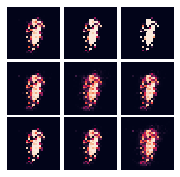

0 200 0.90896487236 1.84371340275


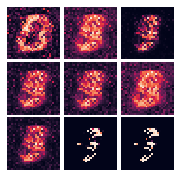

0 400 0.970082879066 1.25558614731


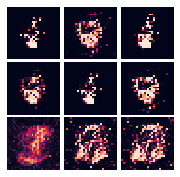

1 0 1.02863609791 1.37516224384


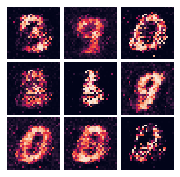

1 200 1.24473929405 0.966210484505


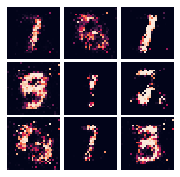

1 400 1.06453633308 0.728103995323


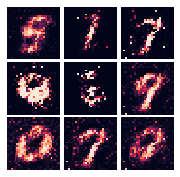

2 0 1.16243076324 0.892238616943


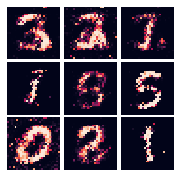

2 200 1.17088794708 1.02539098263


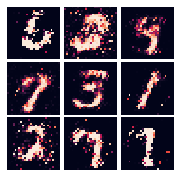

2 400 1.20820581913 1.05640733242


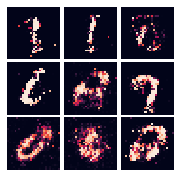

3 0 1.2516105175 0.863601982594


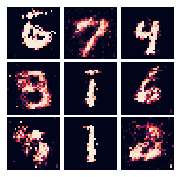

3 200 1.14101326466 1.22260332108


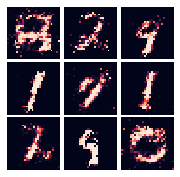

3 400 1.29530835152 1.0272436142


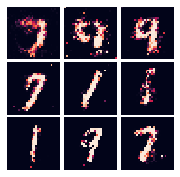

4 0 1.17081260681 1.07765698433


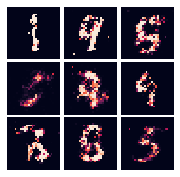

4 200 1.18175768852 0.970902085304


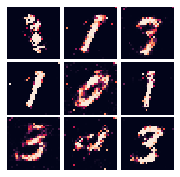

4 400 1.29842281342 0.783955991268


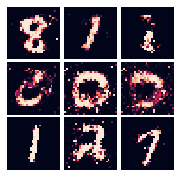

5 0 1.19032454491 1.21221721172


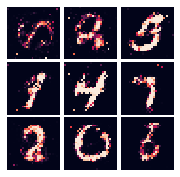

5 200 1.33592748642 1.03147423267


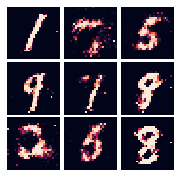

5 400 1.27556848526 1.02624094486


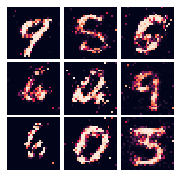

6 0 1.16758453846 0.895471632481


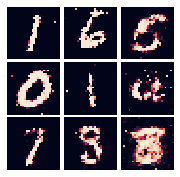

6 200 1.26289749146 0.796397447586


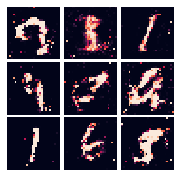

6 400 1.37577772141 0.858405351639


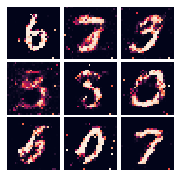

7 0 1.41282129288 0.898970007896


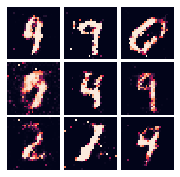

7 200 1.22890925407 0.803263425827


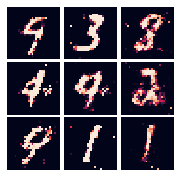

7 400 1.26768660545 0.738085627556


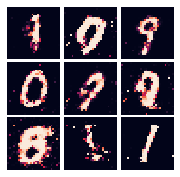

8 0 1.24368000031 1.03633534908


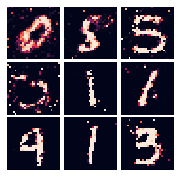

8 200 1.28068137169 0.884463071823


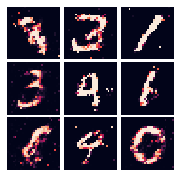

8 400 1.21924304962 0.96650749445


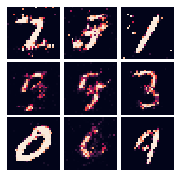

9 0 1.27676701546 0.885160386562


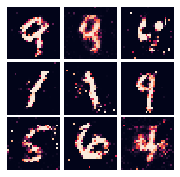

9 200 1.3095202446 0.855010688305


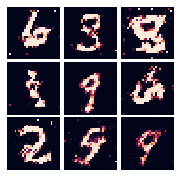

9 400 1.3282957077 0.824815392494


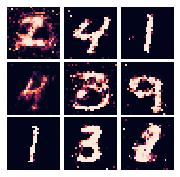

In [8]:
for e in range(10):
    for step, (images, y) in enumerate(mnist_train_loader):
        optim_dis.zero_grad()
        noise = Variable((2 * torch.rand([batch_size, noise_dim]) - 1).cuda())
        images_real = Variable(images.view([batch_size, -1]).cuda())
        images_fake = gen(noise).detach()
        logits_real = dis(2 * images_real - 1)
        logits_fake = dis(images_fake)
        loss_d_real = criterion(logits_real, torch.ones_like(logits_real))
        loss_d_fake = criterion(logits_fake, torch.zeros_like(logits_fake))
        loss_d = loss_d_real + loss_d_fake
        # discriminator optimize
        loss_d.backward()
        optim_dis.step()

        # generator optimize
        optim_gen.zero_grad()
        noise = Variable((2 * torch.rand([batch_size, noise_dim]) - 1).cuda())
        images_fake = gen(noise)
        logits_fake = dis(images_fake)
        loss_g = criterion(logits_fake, torch.ones_like(logits_fake))
        loss_g.backward()
        optim_gen.step()

        if step % 200 == 0:
            print e, step, loss_d.data[0], loss_g.data[0]
            imgs = images_fake.data.cpu().numpy().reshape(batch_size, 28, 28)
            show_images(imgs[0:9])
            plt.show()
    
    